In [1]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('AEP_hourly.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])

In [2]:
df = df.set_index('Datetime')
df = df.groupby(df.index).mean()
df = df.asfreq('h')

In [5]:
df['AEP_MW'] = df['AEP_MW'].ffill()
daily_df = df.resample('D').mean()

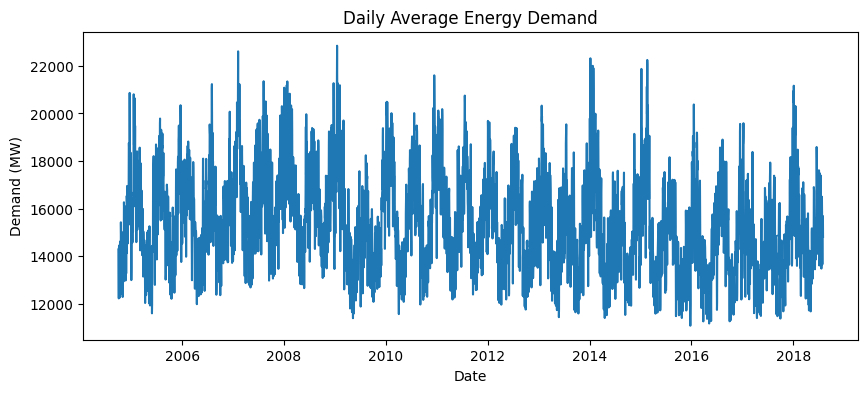

In [6]:
plt.figure(figsize=(10, 4))
plt.plot(daily_df.index, daily_df['AEP_MW'])
plt.title('Daily Average Energy Demand')
plt.xlabel('Date')
plt.ylabel('Demand (MW)')
plt.show()


In [7]:
train = daily_df.iloc[:-365]
test = daily_df.iloc[-365:]

print(train.shape, test.shape)

(4690, 1) (365, 1)


In [10]:
!pip install statsmodels

   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   -- ------------------------------------- 0.5/9.5 MB 5.6 MB/s eta 0:00:02
   ------- -------------------------------- 1.8/9.5 MB 5.6 MB/s eta 0:00:02
   ------------- -------------------------- 3.1/9.5 MB 5.8 MB/s eta 0:00:02
   --------------- ------------------------ 3.7/9.5 MB 5.8 MB/s eta 0:00:02
   --------------------- ------------------ 5.2/9.5 MB 5.6 MB/s eta 0:00:01
   -------------------------- ------------- 6.3/9.5 MB 5.5 MB/s eta 0:00:01
   ------------------------------ --------- 7.3/9.5 MB 5.4 MB/s eta 0:00:01
   ----------------------------------- ---- 8.4/9.5 MB 5.2 MB/s eta 0:00:01
   ---------------------------------------  9.4/9.5 MB 5.2 MB/s eta 0:00:01
   ---------------------------------------- 9.5/9.5 MB 5.1 MB/s eta 0:00:00

   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
  


[notice] A new release of pip is available: 25.1.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(train['AEP_MW'])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

ADF Statistic: -7.298211279734968
p-value: 1.360217034849945e-10


In [12]:
train_diff = train['AEP_MW'].diff().dropna()
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train['AEP_MW'], order=(1,1,1))
model_fit = model.fit()

print(model_fit.summary())
forecast = model_fit.forecast(steps=len(test))
forecast = pd.Series(forecast, index=test.index)


                               SARIMAX Results                                
Dep. Variable:                 AEP_MW   No. Observations:                 4690
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -39200.094
Date:                Fri, 06 Feb 2026   AIC                          78406.187
Time:                        23:33:01   BIC                          78425.546
Sample:                    10-01-2004   HQIC                         78412.994
                         - 08-03-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4664      0.032    -14.780      0.000      -0.528      -0.405
ma.L1          0.7603      0.021     35.693      0.000       0.719       0.802
sigma2       1.15e+06   2.23e+04     51.485      0.0

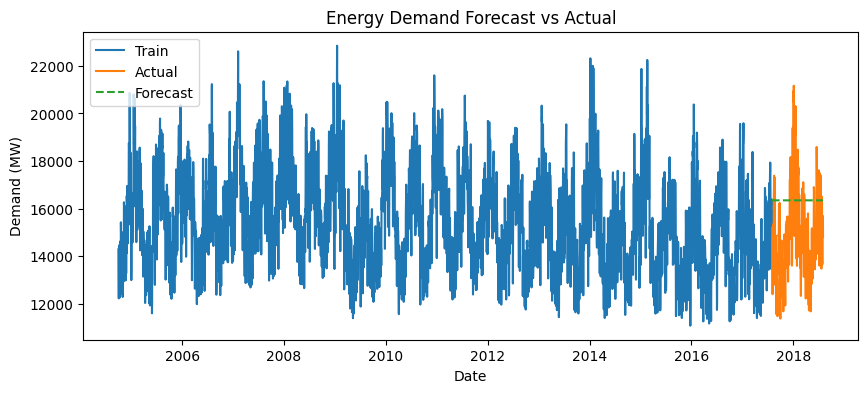

In [13]:
plt.figure(figsize=(10,4))
plt.plot(train.index, train['AEP_MW'], label='Train')
plt.plot(test.index, test['AEP_MW'], label='Actual')
plt.plot(forecast.index, forecast, label='Forecast', linestyle='--')
plt.title('Energy Demand Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Demand (MW)')
plt.legend()
plt.show()


In [14]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(test['AEP_MW'], forecast)
mape = (abs((test['AEP_MW'] - forecast) / test['AEP_MW']).mean()) * 100

print("MAE:", mae)
print("MAPE:", mape)
future_forecast = model_fit.get_forecast(steps=30)
future_mean = future_forecast.predicted_mean
confidence_intervals = future_forecast.conf_int()


MAE: 1947.2010843133683
MAPE: 13.796597860230172


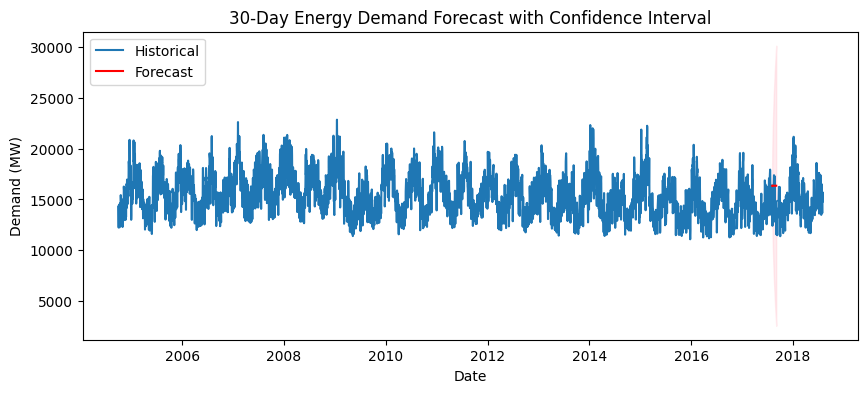

In [15]:
plt.figure(figsize=(10,4))
plt.plot(daily_df.index, daily_df['AEP_MW'], label='Historical')
plt.plot(future_mean.index, future_mean, label='Forecast', color='red')
plt.fill_between(
    confidence_intervals.index,
    confidence_intervals.iloc[:,0],
    confidence_intervals.iloc[:,1],
    color='pink',
    alpha=0.3
)
plt.title('30-Day Energy Demand Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Demand (MW)')
plt.legend()
plt.show()
